In [17]:
#Author tdrown@hardinet.org 3/21/2023
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

os.chdir(r'C:\Users\tdrown\Desktop\Data Center Blog Post\Construction Cost Data')

In [59]:
data_file = r"C:\Users\tdrown\Desktop\Data Center Blog Post\Construction Cost Data\CoStar Rent.xlsx"
data_head = ['quarter', 'rent']

             rent
date             
2000-01-01  23.51
2000-04-01  23.48
2000-07-01  24.64
2000-10-01  26.63
2001-01-01  25.85
2001-04-01  25.64
2001-07-01  25.81
2001-10-01  25.17
2002-01-01  24.86
2002-04-01  22.77


<AxesSubplot:xlabel='date'>

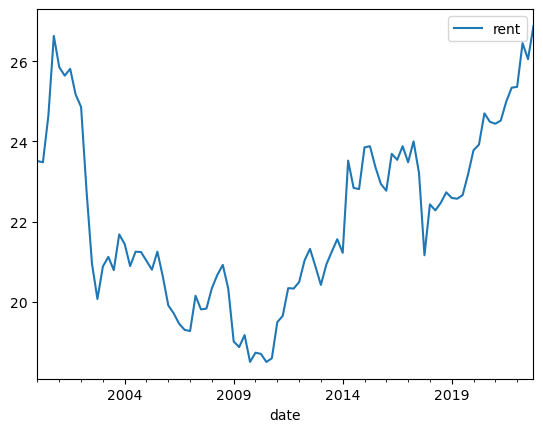

In [85]:
data = pd.read_excel(data_file, header=0, usecols='A:B', names=data_head)
data.quarter = data.quarter.str.replace(' ', '-')
data['date'] = pd.PeriodIndex(data.quarter, freq='Q').to_timestamp()

data = data[['date', 'rent']].copy()
data.set_index('date', inplace=True)

data.rent = pd.to_numeric(data.rent, errors='coerce')
data = data[data.index >='2000-01-01'].copy() #Filter the messy early data
print(data.head(10))
data.plot()

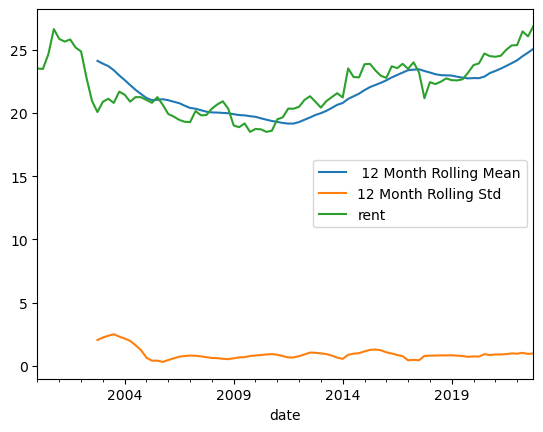

In [87]:
timeseries = data['rent']
timeseries.rolling(12).mean().plot(label = ' 12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

<Figure size 640x480 with 0 Axes>

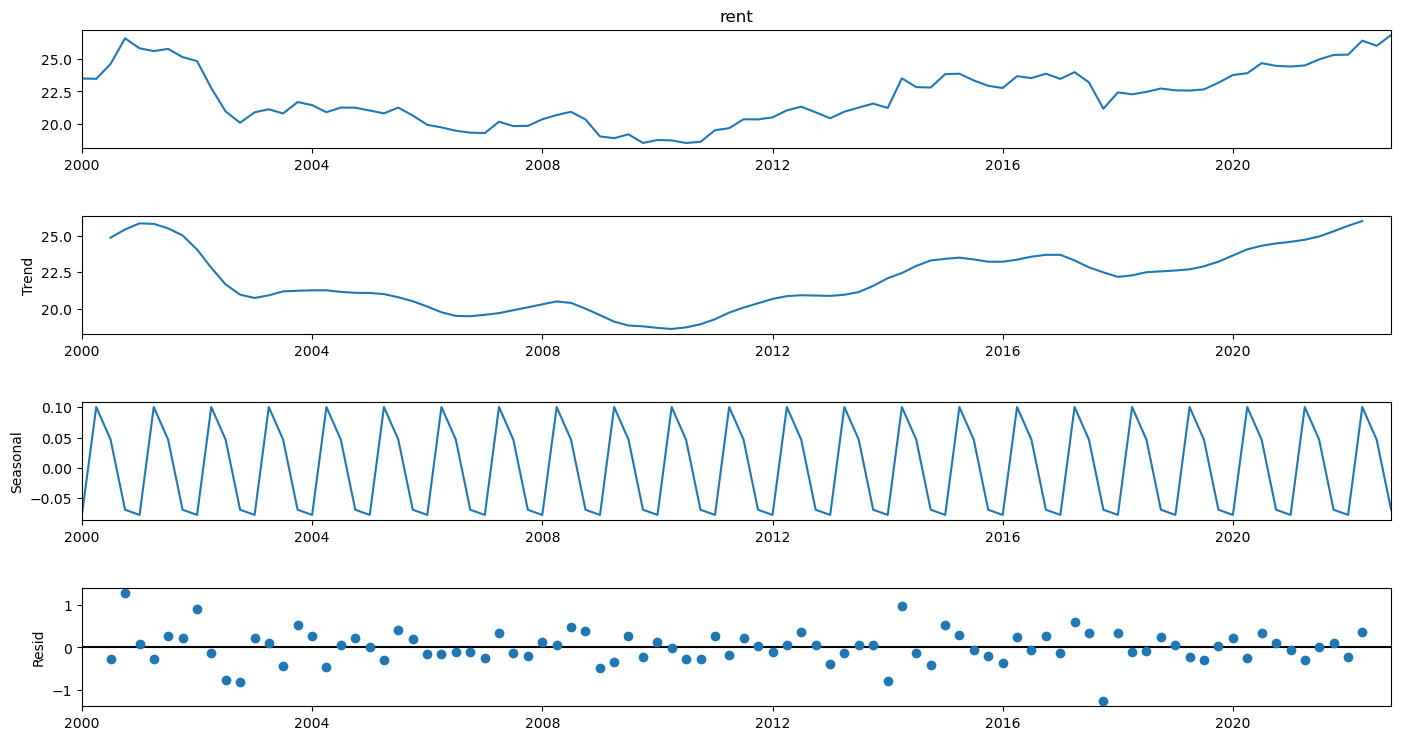

In [89]:
#Seasonality Trend - Quarter
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['rent'])
figure = plt.figure()
figure = decomposition.plot()
figure.set_size_inches(15, 8)

In [93]:
def check_adf(data):
    test_result = adfuller(data)
    print('ADF Test:')
    labels = ['ADF Statistic', 'p-value', 'No. of Lags Used', 'Number of Obs']

    for value,label in zip(test_result,labels):
        print (label+r':'+str(value))
    if test_result[1] <= 0.05:
        print ("Reject null hypothesis and data is stationary")
    else:
        print ("Fail to reject H0 thereby data is non-stationary")

        
check_adf(data.rent)

ADF Test:
ADF Statistic:-0.805872333066801
p-value:0.8173910252569301
No. of Lags Used:0
Number of Obs:91
Fail to reject H0 thereby data is non-stationary


<Figure size 640x480 with 0 Axes>

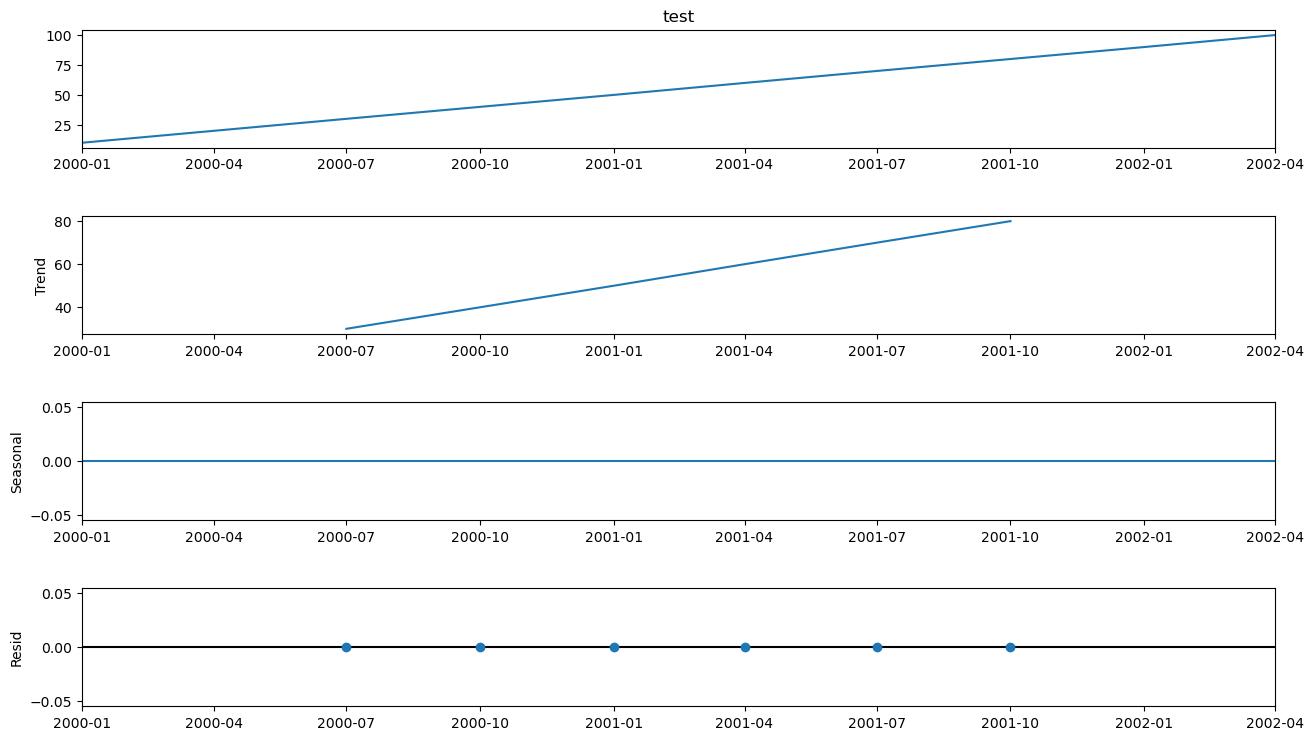

In [106]:
x = [10,20,30,40,50,60,70,80,90,100]
y = data.index[0:10]

df = pd.DataFrame(x, index=y, columns=['test'])
decomposition = seasonal_decompose(df['test'])
figure = plt.figure()
figure = decomposition.plot()
figure.set_size_inches(15, 8)

In [109]:
train = data[data.index < '2020-01-01'].copy()
test = data[data.index >= '2020-01-01'].copy()

import pmdarima as pm
# exhaustive grid-search
gs_model = pm.auto_arima(data.rent, max_p=11, max_q=11, max_d=3,
                         max_D=3, max_P=1 , max_Q=1,  m=12,
                         information_criterion='aic', trace=True,
                         out_of_sample_size=len(test), 
                         error_action='ignore', max_order=None, stepwise=False)

# stepwise search
step_model = pm.auto_arima(data.rent, m=12, information_criterion='aic',
                           trace=True, out_of_sample_size=len(test),
                           error_action='ignore', max_order=None)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=196.201, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=194.246, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=195.472, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=194.022, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=197.894, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=195.978, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=197.159, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=195.885, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=199.819, Time=0.04 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=197.978, Time=0.08 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=199.126, Time=0.08 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=197.972, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=199.670, Time=0.05 sec
 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=198.684, Time=0.11 sec
 ARIMA(0,1,3)(1,0,0)[12] intercept   : AIC=199.620, Time=0.10 sec
 ARIMA(0,1

 ARIMA(2,1,7)(1,0,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,8)(0,0,0)[12] intercept   : AIC=209.619, Time=0.27 sec
 ARIMA(2,1,8)(0,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,8)(1,0,0)[12] intercept   : AIC=209.693, Time=0.36 sec
 ARIMA(2,1,8)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,9)(0,0,0)[12] intercept   : AIC=205.248, Time=0.41 sec
 ARIMA(2,1,9)(0,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,1,9)(1,0,0)[12] intercept   : AIC=213.473, Time=0.62 sec
 ARIMA(2,1,9)(1,0,1)[12] intercept   : AIC=209.974, Time=0.87 sec
 ARIMA(2,1,10)(0,0,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,10)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,1,10)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,1,10)(1,0,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,1,11)(0,0,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,1,11)(0,0,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,1,11)(1,0,0)[12] intercept   : AIC=

 ARIMA(5,1,4)(0,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,4)(1,0,0)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(5,1,4)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(5,1,5)(0,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(5,1,5)(0,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(5,1,5)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(5,1,5)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(5,1,6)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(5,1,6)(0,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(5,1,6)(1,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(5,1,6)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(5,1,7)(0,0,0)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,7)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(5,1,7)(1,0,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(5,1,7)(1,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(5,1,8)(0,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(5

 ARIMA(8,1,1)(0,0,1)[12] intercept   : AIC=208.884, Time=0.21 sec
 ARIMA(8,1,1)(1,0,0)[12] intercept   : AIC=209.437, Time=0.33 sec
 ARIMA(8,1,1)(1,0,1)[12] intercept   : AIC=207.799, Time=0.67 sec
 ARIMA(8,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(8,1,2)(0,0,1)[12] intercept   : AIC=208.521, Time=0.60 sec
 ARIMA(8,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(8,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(8,1,3)(0,0,0)[12] intercept   : AIC=210.988, Time=0.40 sec
 ARIMA(8,1,3)(0,0,1)[12] intercept   : AIC=207.633, Time=0.66 sec
 ARIMA(8,1,3)(1,0,0)[12] intercept   : AIC=207.594, Time=0.85 sec
 ARIMA(8,1,3)(1,0,1)[12] intercept   : AIC=212.883, Time=0.93 sec
 ARIMA(8,1,4)(0,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(8,1,4)(0,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(8,1,4)(1,0,0)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(8,1,4)(1,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(8,1,5)(0,0,0)[12] intercept   :

 ARIMA(10,1,9)(1,0,1)[12] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(10,1,10)(0,0,0)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(10,1,10)(0,0,1)[12] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(10,1,10)(1,0,0)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(10,1,10)(1,0,1)[12] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(10,1,11)(0,0,0)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(10,1,11)(0,0,1)[12] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(10,1,11)(1,0,0)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(10,1,11)(1,0,1)[12] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(11,1,0)(0,0,0)[12] intercept   : AIC=211.694, Time=0.35 sec
 ARIMA(11,1,0)(0,0,1)[12] intercept   : AIC=212.329, Time=0.45 sec
 ARIMA(11,1,0)(1,0,0)[12] intercept   : AIC=212.715, Time=0.78 sec
 ARIMA(11,1,0)(1,0,1)[12] intercept   : AIC=211.517, Time=1.50 sec
 ARIMA(11,1,1)(0,0,0)[12] intercept   : AIC=212.968, Time=0.50 sec
 ARIMA(11,1,1)(0,0,1)[12] intercept   : AIC=214.342, Time=0.53 sec
 ARIMA(11,1,1)(1,0,0)[1

In [137]:
data.index

DatetimeIndex(['2000-01-01', '2000-04-01', '2000-07-01', '2000-10-01',
               '2001-01-01', '2001-04-01', '2001-07-01', '2001-10-01',
               '2002-01-01', '2002-04-01', '2002-07-01', '2002-10-01',
               '2003-01-01', '2003-04-01', '2003-07-01', '2003-10-01',
               '2004-01-01', '2004-04-01', '2004-07-01', '2004-10-01',
               '2005-01-01', '2005-04-01', '2005-07-01', '2005-10-01',
               '2006-01-01', '2006-04-01', '2006-07-01', '2006-10-01',
               '2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
      

                                      SARIMAX Results                                       
Dep. Variable:                                 rent   No. Observations:                   80
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -83.168
Date:                              Mon, 27 Mar 2023   AIC                            172.335
Time:                                      11:51:08   BIC                            179.443
Sample:                                  01-01-2000   HQIC                           175.183
                                       - 10-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3681      0.412     -0.893      0.372      -1.176       0.440
ma.S.L12       0.71

C:\Users\tdrown\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\tdrown\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


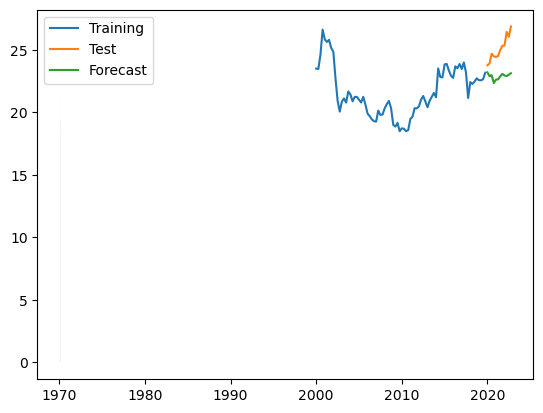

In [131]:
#(010)(101,12)
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(0,1,0), seasonal_order=(1,0,1,12))
result = model.fit()
print(result.summary())

fcst = result.get_forecast(steps=12)
y_pred_df = fcst.conf_int(alpha = 0.05)
y_pred_df['predictions'] = result.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.dropna(subset='predictions', inplace=True)
print(y_pred_df)

plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(y_pred_df.predictions, label='Forecast')
plt.fill_between(y_pred_df['upper rent'], y_pred_df['lower rent'])
plt.legend()
plt.show()

C:\Users\tdrown\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\tdrown\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 rent   No. Observations:                   92
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -92.609
Date:                              Mon, 27 Mar 2023   AIC                            191.218
Time:                                      14:47:21   BIC                            198.751
Sample:                                  01-01-2000   HQIC                           194.257
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5895      0.341     -1.728      0.084      -1.258       0.079
ma.S.L12       0.99

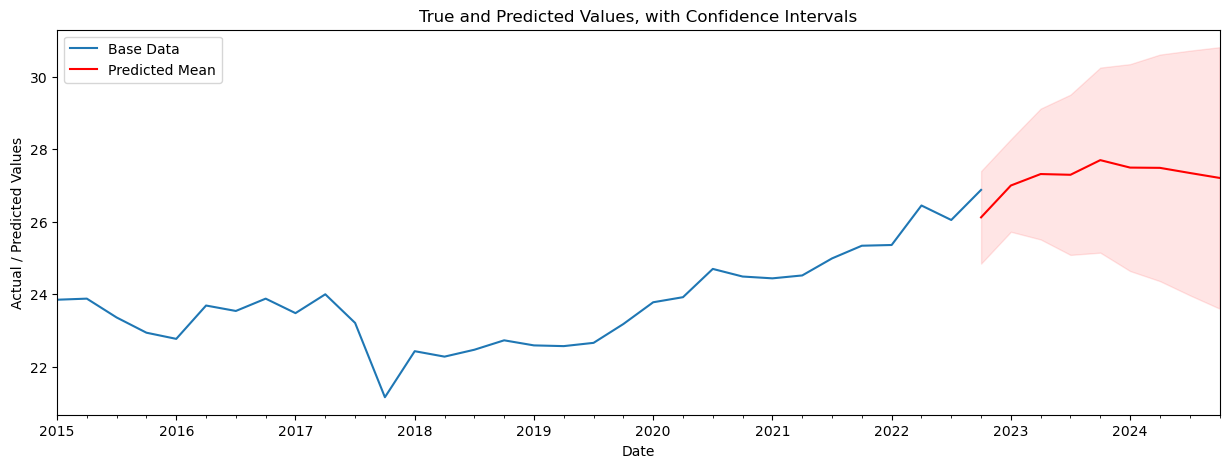

In [166]:
model = SARIMAX(data.rent, order=(0,1,0), seasonal_order=(1,0,1,12))
result = model.fit()
print(result.summary())

y_pred = result.get_forecast(12)
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df['prediction'] = result.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

preds_df = (result.get_prediction(start='2022-10-01', end='2024-10-01').summary_frame())
print(preds_df.head())

fig, ax = plt.subplots(figsize=(15,5))
ax = data['rent'][data.index >= '2015-01-01'].plot(label='Base Data')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Date',
    ylabel='Actual / Predicted Values'
)
preds_df['mean'].plot(ax=ax, style='r', label='Predicted Mean')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
y_pred_df['prediction']
legend = ax.legend(loc='upper left')
plt.show()

In [141]:
print(y_pred_df)
print(preds_df)
y_pred_df.to_excel('rent forecast output.xlsx')

            lower rent  upper rent  prediction
2023-01-01   25.724970   28.278092   27.001531
2023-04-01   25.512468   29.123128   27.317798
2023-07-01   25.086228   29.508366   27.297297
2023-10-01   25.148307   30.254552   27.701429
2024-01-01   24.641151   30.350107   27.495629
2024-04-01   24.363356   30.613505   27.488431
2024-07-01   23.973445   30.721523   27.347484
2024-10-01   23.605114   30.816824   27.210969
2025-01-01   23.578363   31.225646   27.402005
2025-04-01   23.668598   31.727949   27.698273
2025-07-01   23.249060   31.700411   27.474736
2025-10-01   23.265885   32.091843   27.678864
rent             mean   mean_se  mean_ci_lower  mean_ci_upper
2022-10-01  26.122821  0.651319      24.846260      27.399382
2023-01-01  27.001531  0.651319      25.724970      28.278092
2023-04-01  27.317798  0.921104      25.512468      29.123128
2023-07-01  27.297297  1.128117      25.086228      29.508366
2023-10-01  27.701429  1.302637      25.148307      30.254552
2024-01-01  27.49

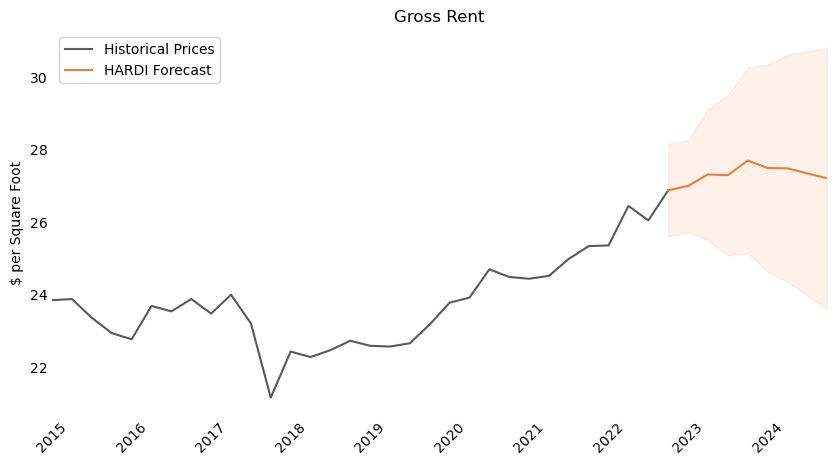

In [184]:
final = pd.read_excel(r'../Final Plots and Output.xlsx', sheet_name='Rent', header=0)
final.Period = final.Period.str.replace(' ', '-')
final['date'] = pd.PeriodIndex(final.Period, freq='Q').to_timestamp()
final.set_index('date', inplace=True)

final = final.loc[final.index >= '2015-01-01'].copy()
final.Period = final.Period.str.replace('-', ' ')

fig, ax = plt.subplots(figsize=(10,5))
ax = final['Rent'][final.index >= '2015-01-01'].plot(style='#595959', label='Historical Prices')
final['Forecast'].plot(ax=ax, style='#ED7D31', label='HARDI Forecast')
ax.fill_between(
    final.index, final['Lower CI'], final['Upper CI'],
    color='#ED7D31', alpha=0.1
)
final['Forecast']
ax.set(
    title='Gross Rent',
    xlabel=None,
    ylabel='$ per Square Foot'
)
legend = ax.legend(loc='upper left')
plt.xticks( rotation=45)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.savefig(r'../DC Rent Forecast.png')
plt.show()

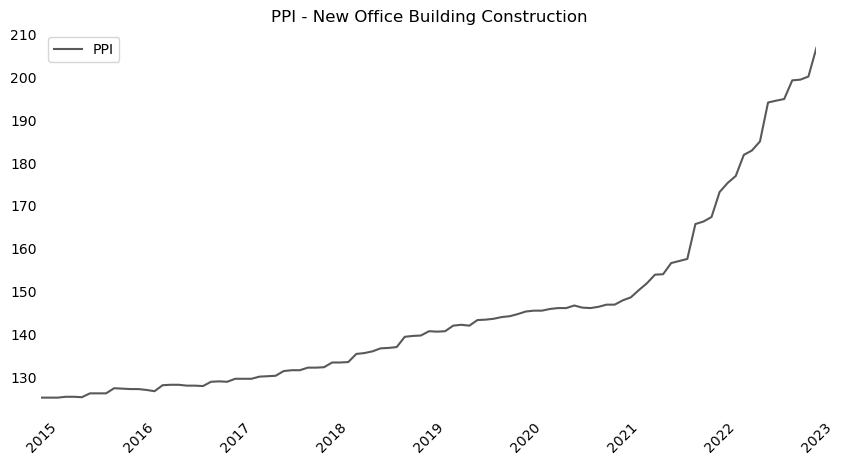

In [197]:
#Load the New Office PPI and present graphically
ppi = pd.read_excel(r'../Final Plots and Output.xlsx', sheet_name='Office PPI')
ppi.DATE = pd.to_datetime(ppi.DATE)
ppi.set_index('DATE', inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
ax = ppi['PPI'][ppi.index >= '2015-01-01'].plot(style='#595959', label='PPI')
ax.set(
    title='PPI - New Office Building Construction',
    xlabel=None,
    ylabel=None
)
legend = ax.legend(loc='upper left')
plt.xticks( rotation=45)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.savefig(r'../Office PPI.png')
plt.show()